In [86]:
import ndlib
import networkx as nx
import ndlib.models.epidemics as ep
import json
import ndlib.models.ModelConfig as mc
import numpy as np
import math
import random
import matplotlib.pyplot as plt


from ndlib.viz.mpl.DiffusionTrend import DiffusionTrend
from ndlib.viz.mpl.DiffusionPrevalence import DiffusionPrevalence

In [37]:
g = nx.erdos_renyi_graph(1000, 0.1)
model = ep.SIRModel(g)
model.available_statuses
# print(json.dumps(model.parameters, indent=2))

cfg = mc.Configuration()
cfg.add_model_parameter('beta', 0.001) # infection rate
cfg.add_model_parameter('gamma', 0.01) # recovery rate
cfg.add_model_parameter("percentage_infected", 0.01)
model.set_initial_status(cfg)

iterations = model.iteration_bunch(200, node_status=True)

trends = model.build_trends(iterations)

100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 128.25it/s]


In [40]:
%matplotlib inline
from ndlib.viz.mpl.DiffusionTrend import DiffusionTrend
viz = DiffusionTrend(model, trends)
viz.plot()

In [39]:
from ndlib.viz.mpl.DiffusionPrevalence import DiffusionPrevalence
viz = DiffusionPrevalence(model, trends)
viz.plot()

## Gillespie's first reaction method 

In [54]:
from simulation import SI_Simulation # Import the model.

ModuleNotFoundError: No module named 'simulation'

In [74]:
class SI_Simulation():
    """
    A class to simulate the SI Model.
    ===================================================
    Input: A - Network adjacency matrix (numpy array) or Networkx graph object.
           lam - Contagion parameter.
           gam - Spontaneous infection parameter.
           i0 - Initial infected fraction.
           prop - Propensity calculation method [ALL,TAKE,FANCY,LOOP,SLICE].
    """

    def __init__(self, A, lam=0.1, gam=0.001, i0=0.1, prop='ALL'):

        # Network setup.
        if type(A)==np.ndarray:
            self.A = A
        elif type(A)==nx.classes.graph.Graph:
            self.A = nx.adj_matrix(A).A
        else:
            raise BaseException("Input an adjacency matrix or networkx object only.")

        # Model Parameters.
        self.N = A.shape[0]
        self.lam = lam/self.N
        self.gam = gam
        self.prop = prop

        # Time-keeping.
        self.t = 0
        self.times = [0]
        
        # Node numbers.
        self.I = [int(i0*self.N)]
        self.S = [self.N-self.I[0]]
        
        # Node states.
        self.X = np.array([1]*self.S[0] +[2]*self.I[0]).reshape((self.N,1))
        np.random.shuffle(self.X)
         
        # Initial propensity setup.        
        self.UpdatePropensityALL() 
        
        # Select which propensity scheme to use.
        if self.prop == 'ALL':
            self.UpdatePropensity = self.UpdatePropensityALL 
        elif self.prop == 'FANCY':
            self.UpdatePropensity = self.UpdatePropensityFANCY 
        elif self.prop == 'TAKE':
            self.UpdatePropensity = self.UpdatePropensityTAKE 
        elif self.prop == 'SLICE':
            self.UpdatePropensity = self.UpdatePropensitySLICE
        elif self.prop == 'LOOP':
            self.UpdatePropensity = self.UpdatePropensityLOOP
        else:
            raise BaseException("Please specify a propensity scheme [ALL,TAKE,FANCY,LOOP,SLICE].")
        return None
        
    def UpdatePropensityALL(self, n_nodes=None):
        self.IP = (self.gam + self.lam*self.A.dot(self.X==2))*(self.X==1)
        return None
    
    def UpdatePropensityTAKE(self,n_nodes):   
        self.IP[n_nodes] = (self.gam + self.lam*np.take(self.A,n_nodes, axis=0).dot(self.X==2))*((np.take(self.X,n_nodes, axis=0)==1))
        return None    
    
    def UpdatePropensityFANCY(self,n_nodes):
        self.IP[n_nodes] = (self.gam + self.lam*self.A[n_nodes].dot(self.X==2))*(self.X[n_nodes]==1)
        return None
        
    def UpdatePropensityLOOP(self,n_nodes):        
        for node in n_nodes:
            self.IP[node] = (self.gam + self.lam*self.A[node].dot(self.X==2))*(self.X[node]==1)
        return None
    
    def UpdatePropensitySLICE(self,n_nodes):        
        nmax, nmin = n_nodes.max()+1, n_nodes.min()
        self.IP[nmin:nmax] = (self.gam + self.lam*self.A[nmin:nmax,:].dot(self.X==2))*(self.X[nmin:nmax]==1)
        return None
        
    def RunIteration(self):
        
        # Termination.
        if self.S[-1] == 0:
            self.S = np.array(self.S, dtype=float)
            self.I = np.array(self.I, dtype=float)
            return False

        # 1. Generate random numbers r1,r2 uniformly distributed in (0,1)
        r1 = np.random.rand()
        r2 = np.random.rand()
        
        # 2. Calculate alpha.
        cumsum = self.IP.cumsum()
        self.alpha = cumsum[-1]

        # 3. Compute the time until the next reaction takes place.
        tau = (1.0/self.alpha)*np.log(float(1.0/r1))
        self.t += tau
        self.times.append(self.t)

        # 4. Compute which reaction takes place.
        index = np.searchsorted(cumsum,r2*self.alpha)

        # 5. Update node states. 
        self.X[index%self.N] = 2
        self.S.append(self.S[-1] - 1)
        self.I.append(self.I[-1] + 1)
            
        # 6. Update propensities
        n1 = np.nonzero(self.A[index%self.N])[0]
        n1 = np.append(n1,index%self.N)
        
        self.UpdatePropensity(n1)
        return True

    def RunToConvergence(self):
        running = True
        while running:
            running = self.RunIteration()
        return None
    
    def IntegrateSolution(self):
        from scipy.integrate import odeint
        gam = self.gam
        lam = self.lam*self.N
        k = self.A.sum(axis=0).mean()

        def deriv(x,t):
            xdot = [-x[0]*(gam + lam*x[1]),
                    +x[0]*(gam + lam*x[1])]
            return xdot

        x0 = [float(self.S[0])/self.N,float(self.I[0])/self.N]
        t = np.linspace(0,self.times[-1],100)
        x = odeint(deriv,x0,t)
        self.solution = x
        return None

In [77]:
G = nx.erdos_renyi_graph(1000,0.95) # Use Networkx to generate a random graph.
print(type(G))

<class 'networkx.classes.graph.Graph'>


In [76]:
%%timeit
model = SI_Simulation(G, lam=0.1, gam=0.05, i0=0.1, prop='TAKE')
model.RunToConvergence()

AttributeError: 'Graph' object has no attribute 'shape'

In [70]:
model = SI_Simulation(G, lam=0.8, gam=0.001, i0=0.0) # Setup the simulation with given parameters.
model.RunToConvergence() # Run the simulation.
model.IntegrateSolution() # Numerically integrate the mean field equations.

AttributeError: 'Graph' object has no attribute 'shape'

In [49]:
# Simulation.
plot(model.times,model.S/model.N, 'g-', label='Susceptible (sim)');
plot(model.times,model.I/model.N, 'r-', label='Infected (sim)');

# Numerical Integration.
t = np.linspace(0,model.times[-1],100)
plot(t, model.solution[:,0],'g--', label='Susceptible (approx)');
plot(t, model.solution[:,1],'r--', label='Infected  (approx)');

xlabel('t')
ylabel('Population Fraction')

legend(bbox_to_anchor=(1.0,0.7));

NameError: name 'plot' is not defined

## Wikipedia code

In [105]:
# Input parameters ####################

# int; total population
N = 1000

# float; maximum elapsed time
T = 100.0

# float; start time
t = 0.0

# float; spatial parameter
V = 100.0

# float; rate of infection after contact
beta = 10.0

# float; rate of cure
gamma = 10.0

# int; initial infected population
n_I = 1

#########################################

# Compute susceptible population, set recovered to zero
n_S = N - n_I
n_R = 0

# Initialize results list
SIR_data = []
SIR_data.append((t, n_S, n_I, n_R))

# Main loop
while t < T:
    if n_I == 0:
        break

    w1 = beta * n_S * n_I / V
    w2 = gamma * n_I
    W = w1 + w2

    # generate exponentially distributed random variable dt
    # using inverse transform sampling
    dt = -math.log(1 - random.uniform(0.0, 1.0)) / W
    t = t + dt

    if random.uniform(0.0, 1.0) < w1 / W:
        n_S = n_S - 1
        n_I = n_I + 1
    else:
        n_I = n_I - 1
        n_R = n_R + 1

    SIR_data.append((t, n_S, n_I, n_R))

with open("SIR_data.txt", "w+") as fp:
    fp.write("\n".join("%f %i %i %i" % x for x in SIR_data))


from scipy.integrate import odeint
import numpy as np

# Numerical solution using an ordinary differential equation solver
ts = np.linspace(0, 2, num=200)
initial_S_I_R = (N - 1, 1, 0)


def differential_SIR(initial_S_I_R, t, _alpha, _beta, V):
    n_S, n_I, n_R = initial_S_I_R
    dS_dt = -beta * n_S / V * n_I
    dI_dt = (beta * n_S / V - gamma) * n_I
    dR_dt = gamma * n_I
    return dS_dt, dI_dt, dR_dt


solution = odeint(differential_SIR, initial_S_I_R, ts, args=(_alpha, _beta, V))
S1, I1, R1 = solution.T

In [111]:
# print(solution)
print(type(SIR_data[1]))



<class 'tuple'>


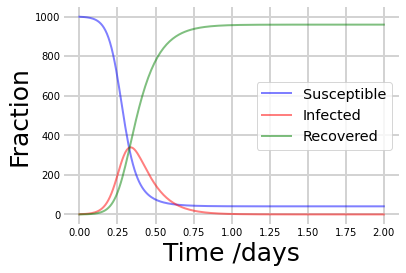

In [94]:
fig = plt.figure()
ax = fig.add_subplot(111, axisbelow=True)
ax.plot(ts, S1, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(ts, I1, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(ts, R1, 'g', alpha=0.5, lw=2, label='Recovered')
ax.set_xlabel('Time /days', size = 25)
ax.set_ylabel('Fraction', size = 25)
#ax.set_ylim(0,1.2)
# ax.set_xlim(0,80)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='lightgray', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.legend(fontsize="x-large")
plt.show()